In [36]:
# mv this notebook in src folder
# or
# set sys path to src folder
import os, sys
path_to_scr_folder=os.path.join(os.path.dirname(os.path.abspath('')), 'src')
sys.path.append(path_to_scr_folder)

In [46]:
import peak_simulation
import read_chroma
import plot

In [41]:
# FILENAME of the chromatogram used as model to create the new chromatogram
model_filename='F:/Bureau/032023-data-Tenax-VOC-COVID/801850-A-C-01-157-split10.cdf'
model_filename=...
model_filename='F:/Bureau/032023-data-Tenax-VOC-COVID/801850-A-C-01-157-split10.cdf'

# PATH where the cdf and the associated ground truth will be created
new_cdf_path=...
new_cdf_path="C:/Users/Stan/Python-2DGC/SIMULATION/"
# NAME of the new chromatogram
cdf_name="test"
cdf_name=...
cdf_name="test"

# FILENAME of the HMDB library. The file alread exists in the src folder but can be recreated. See README.md https://github.com/Easy47/Python-2DGC#if-you-need-to-simulate-data (2.)
lib_path='C:/Users/Stan/Python-2DGC/src/lib_EIB_gt.mgf'
lib_path=...
lib_path='C:/Users/Stan/Python-2DGC/src/lib_EIB_gt.mgf'

# FILENAME of the HMDB library spectra pairwise scores
scores_path='C:/Users/Stan/Python-2DGC/src/lib_scores.json'
scores_path=...
scores_path='C:/Users/Stan/Python-2DGC/src/lib_scores.json'


In [42]:
params=peak_simulation.simulation_from_cdf_model(new_cdf_path=new_cdf_path, cdf_name=cdf_name, model_filename=model_filename, lib_path=lib_path, scores_path=scores_path, noise_loc=1000.0, noise_scale=500.0, min_overlap=0.70, max_overlap=0.99, intensity_range_min=60000000, intensity_range_max=90000000)

1/14 1/6
1/14 2/6
1/14 3/6
1/14 4/6
1/14 5/6
1/14 6/6
2/14 1/6
2/14 2/6
2/14 3/6
2/14 4/6
2/14 5/6
2/14 6/6
3/14 1/6
3/14 2/6
3/14 3/6
3/14 4/6
3/14 5/6
3/14 6/6
4/14 1/6
4/14 2/6
4/14 3/6
4/14 4/6
4/14 5/6
4/14 6/6
5/14 1/6
5/14 2/6
5/14 3/6
5/14 4/6
5/14 5/6
5/14 6/6
6/14 1/6
6/14 2/6
6/14 3/6
6/14 4/6
6/14 5/6
6/14 6/6
7/14 1/6
7/14 2/6
7/14 3/6
7/14 4/6
7/14 5/6
7/14 6/6
8/14 1/6
8/14 2/6
8/14 3/6
8/14 4/6
8/14 5/6
8/14 6/6
9/14 1/6
9/14 2/6
9/14 3/6
9/14 4/6
9/14 5/6
9/14 6/6
10/14 1/6
10/14 2/6
10/14 3/6
10/14 4/6
10/14 5/6
10/14 6/6
11/14 1/6
11/14 2/6
11/14 3/6
11/14 4/6
11/14 5/6
11/14 6/6
12/14 1/6
12/14 2/6
12/14 3/6
12/14 4/6
12/14 5/6
12/14 6/6
13/14 1/6
13/14 2/6
13/14 3/6
13/14 4/6
13/14 5/6
13/14 6/6
14/14 1/6
14/14 2/6
14/14 3/6
14/14 4/6
14/14 5/6
14/14 6/6


c:\Users\Stan\Python-2DGC\src\peak_simulation.py:1001: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clusters_created_points_spectra.append(np.array(spectra))


12 499
new_chromato_cube shape:  (488, 2160, 250)


Plot the created chromatogram

In [44]:
chromato_obj_new=read_chroma.read_chroma(new_cdf_path + '/' + cdf_name + ".cdf")

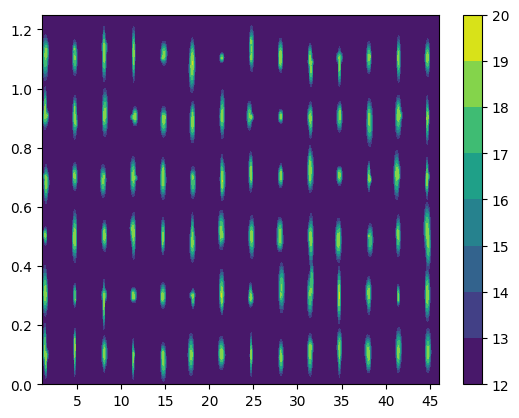

In [47]:
plot.visualizer((chromato_obj_new[0], chromato_obj_new[1]))